# 트랜스포머로 만드는 K-대화형 챗봇
신난다!

## 필요한 패키지 임포트

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
print("슝=3")

슝=3


## 데이터 수집과 전처리

### 데이터 로드 함수 정의, 사용

In [7]:
# 데이터 불러오기 초기 버전
# lms의 방식으로 데이터를 받아올 생각을 하다가
# 한 문장에 질문과 대답이 있는 이번 데이터셋은 어떻게 받아와야 할지 고민함.
# 각 문장을 받아와서 콤마 뒤에 띄어쓰기가 없는 부분을 나눠지는 지점으로 이해함.
# 이 함수도 제대로 작동하지만, 아래 코드블럭 함수로 훨씬 간단하게 데이터 로드가 가능함.
def load_chat_data(filepath):
    # 데이터 불러오기
    with open(filepath, 'r', encoding='utf-8') as file:
        raw_data = file.read().strip()

    # 각 줄이 하나의 샘플 (질문, 대답, 라벨)
    lines = raw_data.split('\n')
    questions, answers = [], []

    for line in lines[1:]:
        # 조건: 콤마(,) 뒤에 공백이 없는 최초의 콤마를 기준으로 split
        match = re.search(r',(?! )', line) # 콤마 뒤에 공백이 없는 경우 찾는 정규표현식 ',(?! )'
        if match:
            split_index = match.start()
            question = line[:split_index].strip()
            rest = line[split_index + 1:].strip()
            # 다시 rest에서 마지막 콤마를 찾아서 대답과 라벨 분리
            last_comma_idx = rest.rfind(',') # 뒤에서부터 콤마를 찾는 rfind
            if last_comma_idx != -1: # 콤마가 존재하면 뒤에 나오는 내용은 라벨로 판단, 삭제
                answer = rest[:last_comma_idx].strip()
                questions.append(question)
                answers.append(answer)

    return questions, answers

In [105]:
# 위 함수의 개선판
# csv 파일은 pd.read_csv()로 읽으면 슬라이싱할 필요 없이 각 문장을 쉽게 얻을 수 있다.
import pandas as pd

def load_chat_data_improved(filepath):
    df = pd.read_csv(filepath)
    
    # 컬럼 이름이 없을 수도 있으니, 기본 열 인덱스로 접근
    # 또는 df.columns 확인 후 명시적으로 'Q', 'A' 같은 이름 사용 가능
    questions = df.iloc[:, 0].astype(str).tolist()
    answers = df.iloc[:, 1].astype(str).tolist()

    return questions, answers

In [106]:
questions, answers = load_chat_data('/aiffel/aiffel/transformer_chatbot/data/ChatbotData .csv')
better_questions, better_answers = load_chat_data_improved('/aiffel/aiffel/transformer_chatbot/data/ChatbotData .csv')
print("질문 예시:", questions[:3])
print("답변 예시:", answers[:3])
print("질문 예시:", better_questions[:3])
print("답변 예시:", better_answers[:3])

질문 예시: ['12시 땡!', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다']
답변 예시: ['하루가 또 가네요.', '위로해 드립니다.', '여행은 언제나 좋죠.']
질문 예시: ['12시 땡!', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다']
답변 예시: ['하루가 또 가네요.', '위로해 드립니다.', '여행은 언제나 좋죠.']


In [108]:
# 개선된 함수를 사용한 데이터로 선택
questions, answers = better_questions, better_answers

### 한글 데이터 전처리 함수 정의, 사용

In [39]:
def preprocess_sentence(sentence):
    sentence = sentence.strip().lower()

    # 구두점 앞뒤로 띄어쓰기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

    # 숫자와 문자 사이 띄어쓰기
    sentence = re.sub(r"(\d)([가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z])", r"\1 \2", sentence)
    sentence = re.sub(r"([가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z])(\d)", r"\1 \2", sentence)
    
    # 영어-한글 또는 한글-영어 사이 띄어쓰기
    sentence = re.sub(r"([a-zA-Z])([가-힣ㄱ-ㅎㅏ-ㅣ])", r"\1 \2", sentence)
    sentence = re.sub(r"([가-힣ㄱ-ㅎㅏ-ㅣ])([a-zA-Z])", r"\1 \2", sentence)
    
    # 자모 1개 이상 앞에 공백 삽입 (앞 단어가 있을 경우)
    sentence = re.sub(r"(?<=[가-힣a-zA-Z0-9])(?=[ㄱ-ㅎㅏ-ㅣ]+)", " ", sentence)

    # 여러 공백 정리
    sentence = re.sub(r'\s+', ' ', sentence)

    # 특수문자 정리 (한글 자모 포함)
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9?.!,]+", " ", sentence)

    return sentence.strip()

In [40]:
# 함수 작동 확인
print(preprocess_sentence("힘들다ㅠㅠ 안녕123ㅋ!"))  

힘들다 ㅠㅠ 안녕 123 ㅋ !


In [41]:
questions = [preprocess_sentence(q) for q in questions]
answers = [preprocess_sentence(a) for a in answers]

In [44]:
# 모음이나 자음 의성어, 의태어 띄어쓰기 확인
print("질문 예시:", questions[6799])
print("답변 예시:", answers[6799])
print("질문 예시:", questions[8272])
print("답변 예시:", answers[8272])

질문 예시: 싱숭생숭 ㅠ
답변 예시: 한동안은 그럴지도 몰라요 .
질문 예시: 착각이였나보네 ㅋㅋ
답변 예시: 상대의 의중을 알긴 쉽지 않죠 .


In [45]:
# 영어와 한글 띄어쓰기 확인
print("질문 예시:", questions[7127])
print("답변 예시:", answers[7127])

질문 예시: 오늘 또 헤어진 사람의 sns 를 봤네
답변 예시: sns 를 삭제하는게 어떨까요 . 미련만 남을 뿐이에요 .


### 단어장 만들기

In [46]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


In [47]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [48]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8157]
END_TOKEN의 번호 : [8158]


In [49]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8159


### 정수 인코딩

In [50]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 전의 21번째 질문 샘플: {}'.format(questions[21]))
print('정수 인코딩 전 21번째 답변 샘플: {}'.format(answers[21]))
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 전의 21번째 질문 샘플: 가스비 장난 아님
정수 인코딩 전 21번째 답변 샘플: 다음 달에는 더 절약해봐요 .
정수 인코딩 후의 21번째 질문 샘플: [5762, 617, 2499, 4167]
정수 인코딩 후의 21번째 답변 샘플: [2365, 7508, 7, 6271, 97, 1]


In [58]:
# 정수 인코딩
def tokenize(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)
  
  return tokenized_inputs, tokenized_outputs

tokenized_questions, tokenized_answers = tokenize(questions, answers)

In [60]:
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenized_questions[21]))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenized_answers[21]))

정수 인코딩 후의 21번째 질문 샘플: [8157, 5762, 617, 2499, 4167, 8158]
정수 인코딩 후의 21번째 답변 샘플: [8157, 2365, 7508, 7, 6271, 97, 1, 8158]


In [61]:
question_lengths = [len(q) for q in tokenized_questions]
answer_lengths = [len(a) for a in tokenized_answers]

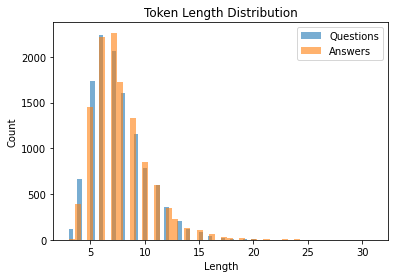

In [65]:
plt.hist(question_lengths, bins=50, alpha=0.6, label='Questions')
plt.hist(answer_lengths, bins=50, alpha=0.6, label='Answers')
plt.xlabel('Length')
plt.ylabel('Count')
plt.title('Token Length Distribution')
plt.legend()
plt.show()

In [66]:
print("질문 최대 길이:", np.max(question_lengths))
print("답변 최대 길이:", np.max(answer_lengths))

print("95% 질문 길이:", np.percentile(question_lengths, 95))
print("95% 답변 길이:", np.percentile(answer_lengths, 95))

질문 최대 길이: 23
답변 최대 길이: 31
95% 질문 길이: 12.0
95% 답변 길이: 13.0


In [77]:
MAX_LENGTH = 15

# 최대 길이를 초과하는 샘플 제거, 패딩
def filter(inputs, outputs):
  filtered_inputs, filtered_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 최대 길이 15 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      filtered_inputs.append(sentence1)
      filtered_outputs.append(sentence2)
  
  # 최대 길이 15로 모든 데이터셋을 패딩
  filtered_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      filtered_inputs, maxlen=MAX_LENGTH, padding='post')
  filtered_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      filtered_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return filtered_inputs, filtered_outputs

questions, answers = filter(tokenized_questions, tokenized_answers)

In [78]:
print('필터링&패딩 후의 21번째 질문 샘플: {}'.format(questions[21]))
print('필터링&패딩 후의 21번째 답변 샘플: {}'.format(answers[21]))

필터링&패딩 후의 21번째 질문 샘플: [8157 5762  617 2499 4167 8158    0    0    0    0    0    0    0    0
    0]
필터링&패딩 후의 21번째 답변 샘플: [8157 2365 7508    7 6271   97    1 8158    0    0    0    0    0    0
    0]


In [79]:
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8159
필터링 후의 질문 샘플 개수: 11569
필터링 후의 답변 샘플 개수: 11569


In [80]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


## 모델 구성

### 포지셔널 인코딩 레이어

In [81]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis], # 0부터 position-1까지의 1차원 벡터를 만들고, (position, 1) 2차원 벡터로 reshape.
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) # 텐서의 차원 순서를 바꿔서 sin cos 번갈아 나오도록
    pos_encoding = tf.reshape(pos_encoding, [position, d_model]) # rank 3에서 rank 2로 변경

    pos_encoding = pos_encoding[tf.newaxis, ...] # 배치 크기 1짜리 텐서로 만들어줌 (rank 2에서 rank 3로)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


### 스케일드 닷 프로덕트 어텐션 함수

In [82]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


### 멀티헤드 어텐션

In [83]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


### 패딩 마스킹

In [84]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


### 룩 어헤드 마스킹

In [85]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1] # 시퀀스 길이
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0) # 1에서 하삼각 행렬을 빼서 마스크 생성
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask) # 두 마스크를 합치는 부분
print("슝=3")

슝=3


### 인코더

#### 인코더 레이어 함수

In [86]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention) # residual connection

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs) # residual connection

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


#### 인코더 구현

In [87]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(MAX_LENGTH, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


### 디코더

#### 디코더 레이어 함수

In [88]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


#### 디코더 구현

In [89]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


### 트랜스포머 정의

In [90]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 self-attention에서 패딩 토큰(<pad>)을 무시하기 위한 마스크입니다.
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 첫 번째 self-attention에서 미래 토큰을 가리기 위한 마스크입니다.
  # 필요시 padding mask와 결합하여 사용됩니다 (이 코드에서는 padding mask 포함 X).
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 두 번째 인코더-디코더 어텐션 블록에서 인코더 입력의 패딩 토큰을 마스킹합니다.
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


### 모델 생성

In [91]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3142912     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## 모델 컴파일 및 학습 진행

### 손실 함수 정의

In [92]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


### 커스텀된 학습률

In [93]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


### 모델 컴파일

In [96]:
learning_rate = CustomSchedule(D_MODEL, warmup_steps=5000)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


### 훈련하기

In [97]:
EPOCHS = 30
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30
181/181 [==============================] - 12s 35ms/step - loss: 1.1589 - accuracy: 0.2890
Epoch 2/30
181/181 [==============================] - 6s 34ms/step - loss: 1.1273 - accuracy: 0.2937
Epoch 3/30
181/181 [==============================] - 6s 34ms/step - loss: 1.0884 - accuracy: 0.2992
Epoch 4/30
181/181 [==============================] - 6s 34ms/step - loss: 1.0358 - accuracy: 0.3073
Epoch 5/30
181/181 [==============================] - 6s 35ms/step - loss: 0.9725 - accuracy: 0.3165
Epoch 6/30
181/181 [==============================] - 6s 34ms/step - loss: 0.8957 - accuracy: 0.3278
Epoch 7/30
181/181 [==============================] - 6s 34ms/step - loss: 0.8087 - accuracy: 0.3411
Epoch 8/30
181/181 [==============================] - 6s 34ms/step - loss: 0.7152 - accuracy: 0.3553
Epoch 9/30
181/181 [==============================] - 6s 34ms/step - loss: 0.6173 - accuracy: 0.3714
Epoch 10/30
181/181 [==============================] - 6s 34ms/step - loss: 0.5215 - accur

## 챗봇 테스트

### 디코더 인퍼런스 함수 구현

In [184]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)
  print(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
  print(sentence[0])
  print(tokenizer.decode(sentence[0].numpy()[1:-5]))
  print(len(sentence[0]))

  # 입력 길이 확인 (추가)
  if len(sentence[0]) > MAX_LENGTH:
      print("[ERROR] 입력 문장이 너무 깁니다. 최대 길이:", MAX_LENGTH)
      return tf.constant([])

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


### 입력 문장에 대한 대답 얻는 함수 구현

In [126]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


### 테스트 진행

In [154]:
sentence_generation('요즘 너무 힘들다 진짜ㅠㅠ')

8
입력 : 요즘 너무 힘들다 진짜ㅠㅠ
출력 : 힘들겠지만 잘 이겨낼 거예요 .


'힘들겠지만 잘 이겨낼 거예요 .'

In [155]:
sentence_generation('요즘 경제는 어떤거 같아?')

9
입력 : 요즘 경제는 어떤거 같아?
출력 : 직접 물어보는 게 좋을 것 같아요 .


'직접 물어보는 게 좋을 것 같아요 .'

In [156]:
sentence_generation('오늘 운이 너무 좋은데?')

8
입력 : 오늘 운이 너무 좋은데?
출력 : 다른 곳에 쓰려고 운을 아껴뒀나봐요 .


'다른 곳에 쓰려고 운을 아껴뒀나봐요 .'

In [157]:
sentence_generation('키위에 ㅋ이 몇 개 존재할까?')

14
입력 : 키위에 ㅋ이 몇 개 존재할까?
출력 : 끝을 받아들이는 것도 중요하답니다 .


'끝을 받아들이는 것도 중요하답니다 .'

In [158]:
sentence_generation('헛소리하지 말고 빨리 잘 생각해봐')

10
입력 : 헛소리하지 말고 빨리 잘 생각해봐
출력 : 세상에 별별 사람들이 다 있죠 .


'세상에 별별 사람들이 다 있죠 .'

In [159]:
sentence_generation('너 유재석이 누군지 알아?')

12
입력 : 너 유재석이 누군지 알아?
출력 : 좋은 사람을 만나 치유하길 바랄게요 .


'좋은 사람을 만나 치유하길 바랄게요 .'

In [186]:
sentence_generation('트랄랄레로 트랄랄라')

트랄랄레로 트랄랄라
tf.Tensor(
[8157  608 8136 8059 8033 8136 8059 8033 2340   93  608 8136 8059 8033
 8136 8059 8033  282 8158], shape=(19,), dtype=int32)
트랄랄레로 트랄
19
[ERROR] 입력 문장이 너무 깁니다. 최대 길이: 15
입력 : 트랄랄레로 트랄랄라
출력 : 


''

In [161]:
sentence_generation('Do you know PSY?')

18
[ERROR] 입력 문장이 너무 깁니다. 최대 길이: 15
입력 : Do you know PSY?
출력 : 


''

In [164]:
sentence_generation('또 왜 그렇게 서있어. 얼른 들어와. 밥 먹게')

14
입력 : 또 왜 그렇게 서있어. 얼른 들어와. 밥 먹게
출력 : 인생은 채워나가는거죠 .


'인생은 채워나가는거죠 .'

In [185]:
sentence_generation('Laugh a lot')

laugh a lot
tf.Tensor([8157 8009 7998 8018 8004 8005 7933 7998 7933 8009 8012 8017 8158], shape=(13,), dtype=int32)
laugh a
13
입력 : Laugh a lot
출력 : 운명은 또 만들어가면 돼요 .


'운명은 또 만들어가면 돼요 .'

## 회고
- 한국어 데이터를 전처리하는 방식에 대해 많이 고민해본 시간이였다.
- 노드 학습 과정에서 트랜스포머의 작동 플로우를 완벽히 이해하기 위해 시간을 많이 쏟았다.
- 위 모델의 답변을 확인하면 입력과 비슷한 평범한 문장에 대해서는 답변이 잘 나오지만,
    - 내용이 너무 특이해서 토크나이징을 하면 입력이 모두 사라지는 경우
    - 내용이 특이하지 않아도 학습 데이터에서 만든 단어장에 입력 단어들이 없는 경우
    - 입력 길이가 MAX_LENGTH보다 긴 경우
    에는 답변이 나오지 않고 오류가 발생하는 것을 확인했다.
- 입력 길이가 15가 넘으면 에러가 나오도록 인퍼런스 함수를 고쳤더니 영어 입력은 알파벳 하나씩 떨어뜨려 인코딩하는 것을 확인
- 학습한 vocab에 없는 단어가 입력되면 해당 단어를 가능한 작은 단위 또는 한 글자 단위로 분해해서 인코딩하는 것을 알게 되었다.
- SubwordTextEncoder의 특성상 띄어쓰기도 모두 토큰화한다는 사실을 알게 되었다.